# CNN model for classification of audio files with genre tags

In [ ]:
#importing the spectrogram images stored in a zip file
import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/colab_data/mels_prepocessed_dortmund.zip","r") as zip_ref:
with zipfile.ZipFile("C:/Uni/Thesis/data/dortmund_dataset/mels_prepocessed_dortmund.zip","r") as zip_ref:
    zip_ref.extractall("C:/Uni/Thesis/data/dortmund_dataset/mel_folder")

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import cv2
pd.options.mode.chained_assignment = None  # default='warn'
import os
import matplotlib.pyplot as plt
import shutil
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model

# Suppress TensorFlow and TF-TRT warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN custom operations

2024-03-12 16:19:59.116111: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 16:19:59.156174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 16:19:59.827024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#checking the no. of spectrograms and their size
# for genre in os.listdir('/content/s_mel'):
#   if genre.startswith('.'):
#     continue
#   mel_dir = os.path.join('/content/s_mel',genre)
#   mel_list = os.listdir(mel_dir)
#   mel_npy = np.load(f'{mel_dir}/{mel_list[0]}')
#   print(genre)
#   print('Count of npy files: ', len(mel_list))
#   print('Size of image: ', mel_npy.shape)

In [ ]:
# # Initialize a list to store all the file paths and labels
# data = []

# # Directory where the melspec folders are located
# root_dir = 'sample_mel'

# # Loop through the directory
# for genre in os.listdir(root_dir):
#     genre_path = os.path.join(root_dir, genre)

#     # Check if it's a directory
#     if os.path.isdir(genre_path):
#         for track_name in os.listdir(genre_path):
#             # Make sure we're only reading .npy files
#             if track_name.endswith('.npy'):
#                 # Append the track name and genre to the list
#                 data.append((track_name, genre))

# # Create a DataFrame with the data
# df = pd.DataFrame(data, columns=['track_name', 'genre'])

# # Write the DataFrame to a CSV file
# df.to_csv('metadata.csv', index=False)

Metadata CSV file has been created with 1886 entries.


In [2]:
df = pd.read_csv('/home/mendu/Thesis/data/metadata/metadata.csv')

In [3]:
df

,track_name,genre
0,ToR___garageband_com_toraudio-Fourty_Two.npy,electronic
1,Van_der_Waal-Dark_Matters.npy,electronic
2,Tone_Matrix-Silver.npy,electronic
3,messyman-OVERDOSE.npy,electronic
4,Cargo_cult-Sol_naciente.npy,electronic
...,...,...
1881,David_Boyles-Saturday.npy,funksoulrnb
1882,Mother_Funk_Conspiracy-FUNKY_MCSUNKE.npy,funksoulrnb
1883,Pennyshaker-Candy.npy,funksoulrnb
1884,The_Blue_Method-Something_Devine.npy,funksoulrnb


## Loading the mtg dataframe and filtering it to include top 5 genres from the sample

In [ ]:
#importing csv that contains the metafile of all the tracks
df_all = pd.read_csv('/content/mtg_cleaned.csv', index_col = [0])

In [ ]:
df_all.head()

,track_id,artist_id,album_id,path,duration,genre,instrument,mood
1,214,14,31,14/214.mp3,124.6,punkrock,NaN,NaN
2,215,14,31,15/215.mp3,151.4,metal,NaN,NaN
3,216,14,31,16/216.mp3,234.9,metal,NaN,NaN
4,217,14,31,17/217.mp3,127.9,punkrock,NaN,NaN
5,218,14,31,18/218.mp3,180.7,punkrock,NaN,NaN


In [ ]:
#list of all the track_ids in the sample zip file
track_ids = [int(file_name.replace('_30-60.npy', '')) for file_name in mel_list]

#filtering only those tracks to the dataset
df = df_all[df_all['track_id'].isin(track_ids)]

#only taking the first genre from the genre column
df['genre'] = df['genre'].str.split(',').str[0]

#only keeping the tracks and genre column
df = df[['track_id', 'genre']]

In [ ]:
#calculating the most frequent genres in the sample and only keeping the top five in the df
genre_count = pd.DataFrame(df.genre.value_counts().rename_axis('genre').reset_index(name='counts'))

#list of top five genres
top_genres = list(genre_count.genre[:10])

#filtering df to only keep
df = df[df['genre'].isin(top_genres)].sort_values(by = 'track_id', ascending = True).reset_index(drop = True)

df

,track_id,genre
0,3524,electronic
1,4629,ambient
2,6606,dance
3,6607,dance
4,6608,dance
...,...,...
3936,1420700,chillout
3937,1420704,dance
3938,1420705,dance
3939,1420706,dance


In [ ]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_id'].values)

In [ ]:
train_track_ids[:5]

[3524, 4629, 6606, 6607, 6608]

# Preprocessing for dortmund files

In [ ]:
# # Path to your 'sample_mel' directory containing genre sub-directories
# root_dir = 's_mel/'

# # Path to the new directory where all the .npy files will be moved
# target_dir = 'mel_folder/'
# os.makedirs(target_dir, exist_ok=True)  # Create the directory if it doesn't exist

# # Walk through each subdirectory in 'sample_mel'
# for genre in os.listdir(root_dir):
#     genre_path = os.path.join(root_dir, genre)

#     # Only consider directories
#     if os.path.isdir(genre_path):
#         for filename in os.listdir(genre_path):
#             if filename.endswith('.npy'):
#                 # Construct the full file paths
#                 old_path = os.path.join(genre_path, filename)
#                 new_path = os.path.join(target_dir, filename)

#                 # Move the file from the old_path to the new_path
#                 shutil.move(old_path, new_path)

# Training the model

In [4]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (img.shape[0], img.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(img.shape, np.float32)

    #adding the noise to the original image
    noisy_image = img + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [5]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_name'])

In [6]:
train_track_ids[:5]

['ToR___garageband_com_toraudio-Fourty_Two.npy',
 'Van_der_Waal-Dark_Matters.npy',
 'Tone_Matrix-Silver.npy',
 'messyman-OVERDOSE.npy',
 'Cargo_cult-Sol_naciente.npy']

In [7]:
#loading the cropped .npy files

folder_path_mel = '/home/mendu/Thesis/data/mel_npy_folder/mel_folder'
filenames = os.listdir(folder_path_mel)

data = []
i = 0

for filename in train_track_ids:
  # filename_npy = str(filename) + '.npy'
  file_path = os.path.join(folder_path_mel, filename)
  img = np.load(file_path)
  data.append(add_gauss_noise(img))
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


ToR___garageband_com_toraudio-Fourty_Two.npy
Van_der_Waal-Dark_Matters.npy
Tone_Matrix-Silver.npy
messyman-OVERDOSE.npy
Cargo_cult-Sol_naciente.npy
Stuart_Elliott-Solitude.npy
Diemembrence-AbolishThyHeavens.npy
Gamsters-Back_From_Jazz.npy
Matt_Taylor_Steel_Razor-The_Quest.npy
COSM-Divinity.npy


In [8]:
data.shape

(1886, 128, 867)

In [9]:
#normalize data
data = data.astype('float32')/255.0

In [10]:
data.shape

(1886, 128, 867)

In [11]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 867, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['genre']), test_size=0.1, random_state=42)

In [12]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)
# # Define a Mixup function
# def mixup(X, y, alpha=0.2):
#     if np.random.rand() < 0.2:  # Apply Mixup to 20% of the images
#         batch_size = X.shape[0]
#         l = np.random.beta(alpha, alpha, batch_size)
#         X_l = l.reshape(batch_size, 1, 1, 1)
#         y_l = l.reshape(batch_size, 1)

#         X_mixup = X * X_l + X[::-1] * (1 - X_l)
#         y_mixup = y * y_l + y[::-1] * (1 - y_l)
#         return X_mixup, y_mixup
#     else:
#         return X, y

# # Create an augmenter for Gaussian noise
# gaussian_noise = iaa.AdditiveGaussianNoise(scale=0.01 * 255)

# # Define the custom generator
# def custom_generator(datagen, gaussian_noise, X_train, Y_train, batch_size):
#     generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
#     while True:
#         X_batch, y_batch = next(generator)

#         # Decide whether to apply Gaussian noise
#         if np.random.rand() < 0.2:  # Apply Gaussian noise to 20% of the images
#             X_batch = gaussian_noise.augment_images(X_batch)

#         # Apply Mixup
#         X_batch, y_batch = mixup(X_batch, y_batch)
#         yield X_batch, y_batch

# # Usage example
# batch_size = 32
# alpha = 0.2  # Adjust Mixup's alpha value if needed
# augmented_data_gen = custom_generator(datagen, gaussian_noise, X_train, y_train, batch_size)



In [13]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]

In [14]:
num_classes

9

In [15]:
#l2 regularisation
ltwo_reg = 0.007

# Initialize the model
model = Sequential()

#Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=(128, 867, 1), use_bias=False))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-12 16:20:23.281079: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 865, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 865, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 432, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 430, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 430, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 215, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 213, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 213, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 106, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 189952)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    24,313,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,407,465 (93.11 MB)

 Trainable params: 24,407,465 (93.11 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))
# history = model.fit(
#     augmented_data_gen,
#     steps_per_epoch=len(X_train) // batch_size,  # Number of steps per epoch
#     epochs=10,  # Number of epochs to train for
#     validation_data=(X_val, y_val)
# )

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.2257 - loss: 4.3917 - val_accuracy: 0.2698 - val_loss: 2.5399
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2913 - loss: 2.4712 - val_accuracy: 0.2698 - val_loss: 2.3716
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.2545 - loss: 2.3794 - val_accuracy: 0.2698 - val_loss: 2.2462
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2658 - loss: 2.3040 - val_accuracy: 0.2698 - val_loss: 2.2096
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2740 - loss: 2.2309 - val_accuracy: 0.2698 - val_loss: 2.1677
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2574 - loss: 2.2365 - val_accuracy: 0.2698 - val_loss: 2.1628
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2749 - loss: 2.1960 - val_accuracy: 0.2910 - val_loss: 2.1411
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2813 - loss: 2.1766 - val_accu

In [21]:
# Train for 10 more epochs
history_20 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), initial_epoch=10)
# history_20 = model.fit(
#     augmented_data_gen,
#     steps_per_epoch=len(X_train) // batch_size, # Number of steps per epoch
#     epochs=20,                                 # Train until epoch 20
#     validation_data=(X_val, y_val),            # Keep validation data the same
#     initial_epoch=10                           # Start from epoch 10
# )

Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.3044 - loss: 2.2072 - val_accuracy: 0.3228 - val_loss: 2.1326
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3254 - loss: 2.1661 - val_accuracy: 0.3122 - val_loss: 2.3003
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3057 - loss: 2.2695 - val_accuracy: 0.2963 - val_loss: 2.1274
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.3291 - loss: 2.1706 - val_accuracy: 0.4286 - val_loss: 2.0057
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3849 - loss: 2.0431 - val_accuracy: 0.3280 - val_loss: 2.3619
Epoch 16/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.3297 - loss: 2.1928 - val_accuracy: 0.4339 - val_loss: 1.9243
Epoch 17/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.3806 - loss: 2.0287 - val_accuracy: 0.3704 - val_loss: 1.9090
Epoch 18/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3790 - loss: 2.0133 - 

In [22]:
# Train for 10 more epochs
history_30 = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), initial_epoch=20)
# history_30 = model.fit(
#     augmented_data_gen,
#     steps_per_epoch=len(X_train) // batch_size, # Number of steps per epoch
#     epochs=30,                                 # Train until epoch 20
#     validation_data=(X_val, y_val),            # Keep validation data the same
#     initial_epoch=20                           # Start from epoch 10
# )

Epoch 21/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.3915 - loss: 1.9658 - val_accuracy: 0.4497 - val_loss: 1.8789
Epoch 22/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.4065 - loss: 1.9289 - val_accuracy: 0.4339 - val_loss: 1.8583
Epoch 23/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4079 - loss: 1.8915 - val_accuracy: 0.3651 - val_loss: 1.9443
Epoch 24/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3810 - loss: 1.9860 - val_accuracy: 0.3757 - val_loss: 1.9687
Epoch 25/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.3825 - loss: 1.9412 - val_accuracy: 0.4497 - val_loss: 1.9354
Epoch 26/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.4120 - loss: 1.9279 - val_accuracy: 0.4709 - val_loss: 1.8395
Epoch 27/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4073 - loss: 1.9110 - val_accuracy: 0.3704 - val_loss: 1.8701
Epoch 28/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4123 - loss: 1.8976 - 

In [16]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/colab_data/cnn_4k_l20.002_30ep.keras')

In [ ]:
# Load the model
loaded_model = load_model('/content/drive/MyDrive/colab_data/cnn_3k_l20.004_30ep.keras')

In [24]:
history_40 = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), initial_epoch=30)

Epoch 31/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.4018 - loss: 1.9255 - val_accuracy: 0.4603 - val_loss: 1.7984
Epoch 32/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.4373 - loss: 1.8609 - val_accuracy: 0.1958 - val_loss: 2.8927
Epoch 33/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2952 - loss: 2.2843 - val_accuracy: 0.4233 - val_loss: 2.0346
Epoch 34/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4220 - loss: 1.9064 - val_accuracy: 0.3704 - val_loss: 1.8936
Epoch 35/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3973 - loss: 1.9609 - val_accuracy: 0.4392 - val_loss: 1.8144
Epoch 36/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4151 - loss: 1.8679 - val_accuracy: 0.4286 - val_loss: 1.8348
Epoch 37/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4176 - loss: 1.9116 - val_accuracy: 0.3386 - val_loss: 1.9601
Epoch 38/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.3989 - loss: 1.8873 - 

In [25]:
history_50 = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), initial_epoch=40)

Epoch 41/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.4032 - loss: 1.9306 - val_accuracy: 0.2434 - val_loss: 2.2296
Epoch 42/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3564 - loss: 2.0496 - val_accuracy: 0.4233 - val_loss: 1.7799
Epoch 43/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4495 - loss: 1.8714 - val_accuracy: 0.3968 - val_loss: 1.9099
Epoch 44/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.4324 - loss: 1.8696 - val_accuracy: 0.3545 - val_loss: 2.0932
Epoch 45/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.3580 - loss: 2.1174 - val_accuracy: 0.3704 - val_loss: 1.9707
Epoch 46/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4130 - loss: 1.8920 - val_accuracy: 0.4603 - val_loss: 1.8045
Epoch 47/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.3688 - loss: 1.9790 - val_accuracy: 0.4180 - val_loss: 1.8450
Epoch 48/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.4287 - loss: 1.9045 - 

In [26]:
history_60 = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data=(X_val, y_val), initial_epoch=50)

Epoch 51/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.4340 - loss: 1.8094 - val_accuracy: 0.4074 - val_loss: 1.8821
Epoch 52/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4375 - loss: 1.8560 - val_accuracy: 0.4974 - val_loss: 1.6981
Epoch 53/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4148 - loss: 1.8369 - val_accuracy: 0.3862 - val_loss: 1.9952
Epoch 54/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 260ms/step - accuracy: 0.3928 - loss: 1.9752 - val_accuracy: 0.4550 - val_loss: 1.7552
Epoch 55/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4500 - loss: 1.7986 - val_accuracy: 0.4233 - val_loss: 1.8729
Epoch 56/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4118 - loss: 1.8753 - val_accuracy: 0.5026 - val_loss: 1.6880
Epoch 57/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4360 - loss: 1.7862 - val_accuracy: 0.4180 - val_loss: 1.8707
Epoch 58/60
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.4383 - loss: 1.8049 - 

In [17]:
from keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper]
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.1953 - loss: 4.3055 - val_accuracy: 0.2698 - val_loss: 2.5558
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.2651 - loss: 2.5314 - val_accuracy: 0.2698 - val_loss: 2.4062
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2507 - loss: 2.4261 - val_accuracy: 0.2698 - val_loss: 2.2924
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.2521 - loss: 2.3513 - val_accuracy: 0.2698 - val_loss: 2.2616
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2681 - loss: 2.2954 - val_accuracy: 0.2698 - val_loss: 2.1991
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2816 - loss: 2.2680 - val_accuracy: 0.2698 - val_loss: 2.1587
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2657 - loss: 2.2480 - val_accuracy: 0.2698 - val_loss: 2.1552
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step - accuracy: 0.2652 - loss: 2.2018 - 

In [ ]:
history_70 = model.fit(X_train, y_train, batch_size=32, epochs=70, validation_data=(X_val, y_val), initial_epoch=60)

Epoch 61/70
54/54 [==============================] - 3s 49ms/step - loss: 1.6572 - accuracy: 0.5345 - val_loss: 1.9154 - val_accuracy: 0.4550
Epoch 62/70
54/54 [==============================] - 2s 42ms/step - loss: 1.8084 - accuracy: 0.4838 - val_loss: 1.7888 - val_accuracy: 0.5132
Epoch 63/70
54/54 [==============================] - 2s 44ms/step - loss: 1.7132 - accuracy: 0.5115 - val_loss: 1.8123 - val_accuracy: 0.4921
Epoch 64/70
54/54 [==============================] - 2s 44ms/step - loss: 1.6513 - accuracy: 0.5292 - val_loss: 1.9443 - val_accuracy: 0.4392
Epoch 65/70
54/54 [==============================] - 2s 40ms/step - loss: 1.6612 - accuracy: 0.5321 - val_loss: 1.7198 - val_accuracy: 0.5238
Epoch 66/70
54/54 [==============================] - 2s 43ms/step - loss: 1.6689 - accuracy: 0.5180 - val_loss: 1.7441 - val_accuracy: 0.5079
Epoch 67/70
54/54 [==============================] - 3s 54ms/step - loss: 1.6602 - accuracy: 0.5268 - val_loss: 1.7230 - val_accuracy: 0.5344
Epoch 

In [ ]:
history_80 = model.fit(X_train, y_train, batch_size=32, epochs=80, validation_data=(X_val, y_val), initial_epoch=70)

In [ ]:
history_90 = model.fit(X_train, y_train, batch_size=32, epochs=90, validation_data=(X_val, y_val), initial_epoch=80)

In [ ]:
history_100 = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), initial_epoch=90)

In [18]:
# last val loss and val acc
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5326 - loss: 1.6024
Validation Loss: 1.6812872886657715, Validation Accuracy: 0.5026454925537109


In [ ]:
# Concatenate the old and new history
full_history = {}
for key in history.history.keys():
    # full_history[key] = history.history[key] + history_20.history[key] + history_30.history[key] + history_40.history[key] + history_50.history[key] + history_60.history[key] + history_70.history[key] + history_80.history[key] + history_90.history[key] + history_100.history[key]
    full_history[key] = history.history[key] + history_20.history[key] + history_30.history[key] + history_40.history[key] + history_50.history[key] + history_60.history[key] + history_70.history[key]

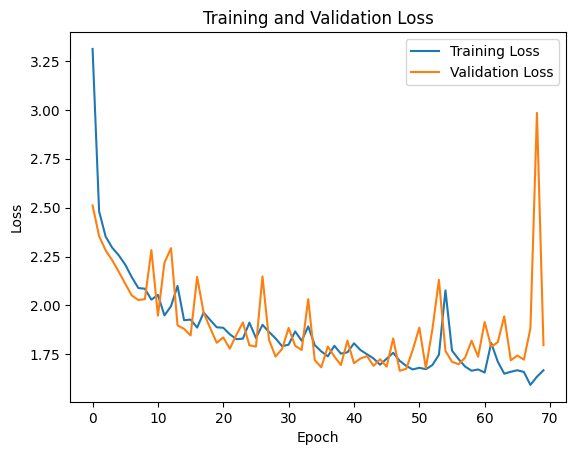

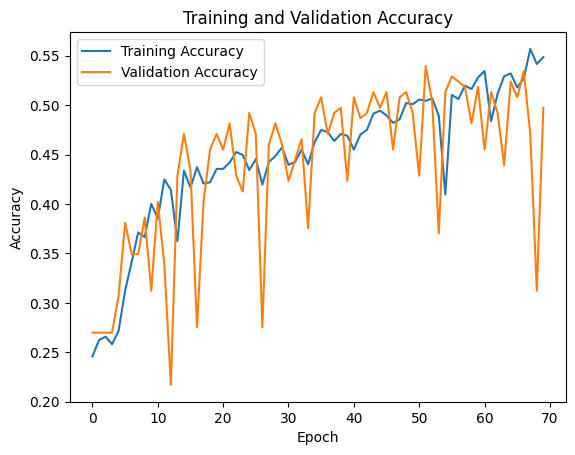

In [ ]:
# Plot training loss
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(full_history['accuracy'], label='Training Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


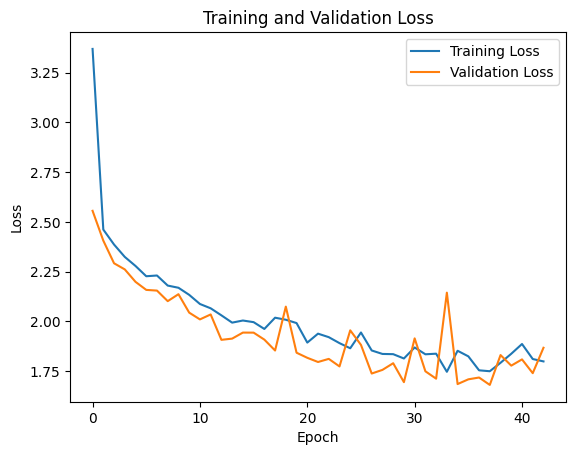

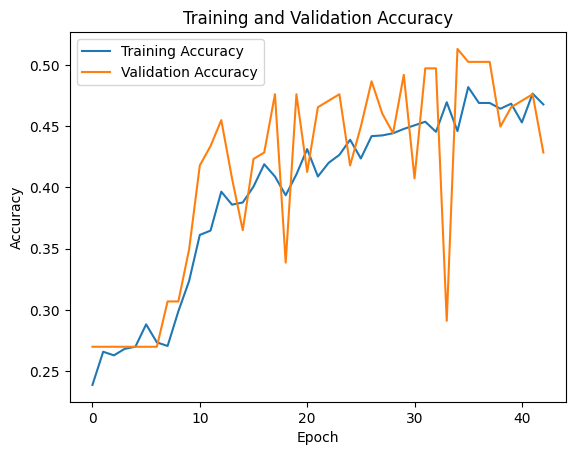

In [19]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam  # Use the optimizer you originally used

# Load the model
model = load_model('/content/drive/MyDrive/colab_data/cnn_3k_l20.004_40ep.keras')  # Replace 'your_model_file.h5' with your actual file name

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train for 10 more epochs
history_50 = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
78/78 [==============================] - 12s 74ms/step - loss: 1.9434 - accuracy: 0.3536 - val_loss: 1.9489 - val_accuracy: 0.3333
Epoch 2/10
78/78 [==============================] - 4s 49ms/step - loss: 1.9264 - accuracy: 0.3681 - val_loss: 1.9657 - val_accuracy: 0.3333
Epoch 3/10
78/78 [==============================] - 4s 53ms/step - loss: 1.9106 - accuracy: 0.3734 - val_loss: 2.0124 - val_accuracy: 0.3301
Epoch 4/10
78/78 [==============================] - 4s 54ms/step - loss: 1.9088 - accuracy: 0.3851 - val_loss: 2.0077 - val_accuracy: 0.3446
Epoch 5/10
78/78 [==============================] - 4s 55ms/step - loss: 1.8709 - accuracy: 0.3976 - val_loss: 2.0197 - val_accuracy: 0.3446
Epoch 6/10
78/78 [==============================] - 4s 47ms/step - loss: 1.8740 - accuracy: 0.4000 - val_loss: 2.0546 - val_accuracy: 0.3349
Epoch 7/10
78/78 [==============================] - 4s 51ms/step - loss: 1.8746 - accuracy: 0.4085 - val_loss: 2.0443 - val_accuracy: 0.3414
Epoch 8/10
7

ValueError: x and y must have same first dimension, but have shapes (50,) and (30,)

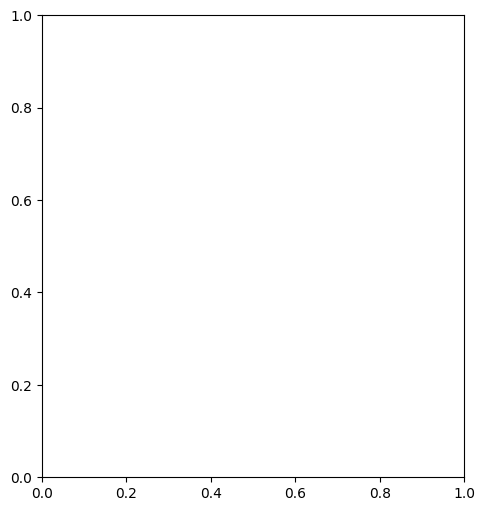

In [ ]:
import matplotlib.pyplot as plt

# Training history for the first 50 epochs
history_50_epochs = {
    'accuracy': [0.2282, 0.2573, 0.2746, 0.2677, 0.2839, 0.2782, 0.2863, 0.2956, 0.2915, 0.2931, 0.3028, 0.2984, 0.3056, 0.2980, 0.3169, 0.3032, 0.3089, 0.3117, 0.3093, 0.3185, 0.3000, 0.3210, 0.3056, 0.3125, 0.3125, 0.3161, 0.3323, 0.3173, 0.3274, 0.3198],
    'val_accuracy': [0.3043, 0.2963, 0.3108, 0.2770, 0.3060, 0.2528, 0.3108, 0.3124, 0.2866, 0.2995, 0.3237, 0.3172, 0.3253, 0.3317, 0.3076, 0.3269, 0.3140, 0.3317, 0.3349, 0.3317, 0.3237, 0.3092, 0.3237, 0.3205, 0.3317, 0.3366, 0.3478, 0.3269, 0.3269, 0.3510],
    'loss': [2.6789, 2.2840, 2.2103, 2.1773, 2.1371, 2.1158, 2.0959, 2.0584, 2.0356, 2.0540, 2.0213, 2.0199, 2.0098, 2.0217, 1.9952, 2.0019, 1.9963, 1.9971, 2.0039, 2.0022, 2.0022, 1.9903, 2.0025, 1.9937, 1.9812, 1.9808, 1.9764, 1.9803, 1.9877, 1.9739],
    'val_loss': [2.2382, 2.1635, 2.1177, 2.0747, 2.0738, 2.0531, 1.9861, 1.9592, 1.9823, 1.9922, 1.9350, 1.9762, 1.9336, 1.9346, 1.9474, 1.9280, 1.9453, 1.9437, 1.9471, 1.9659, 1.9301, 1.9330, 1.9274, 1.9205, 1.9735, 1.9322, 1.9408, 1.9660, 1.9439, 1.9344]
}

# Training history for the next 30 epochs
history_30_epochs = {
    'accuracy': [0.3536, 0.3681, 0.3734, 0.3851, 0.3976, 0.4000, 0.4085, 0.4222, 0.4206, 0.4480],
    'val_accuracy': [0.3333, 0.3333, 0.3301, 0.3446, 0.3446, 0.3349, 0.3414, 0.3398, 0.3253, 0.3301],
    'loss': [1.9434, 1.9264, 1.9106, 1.9088, 1.8709, 1.8740, 1.8746, 1.8742, 1.8445, 1.8343],
    'val_loss': [1.9489, 1.9657, 2.0124, 2.0077, 2.0197, 2.0546, 2.0443, 2.0582, 2.0573, 2.0960]
}

# Plotting training accuracy and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 51), history_50_epochs['accuracy'], label='Training Accuracy (Epochs 1-50)')
plt.plot(range(1, 31), history_30_epochs['accuracy'], label='Training Accuracy (Epochs 51-80)')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), history_50_epochs['loss'], label='Training Loss (Epochs 1-50)')
plt.plot(range(1, 31), history_30_epochs['loss'], label='')


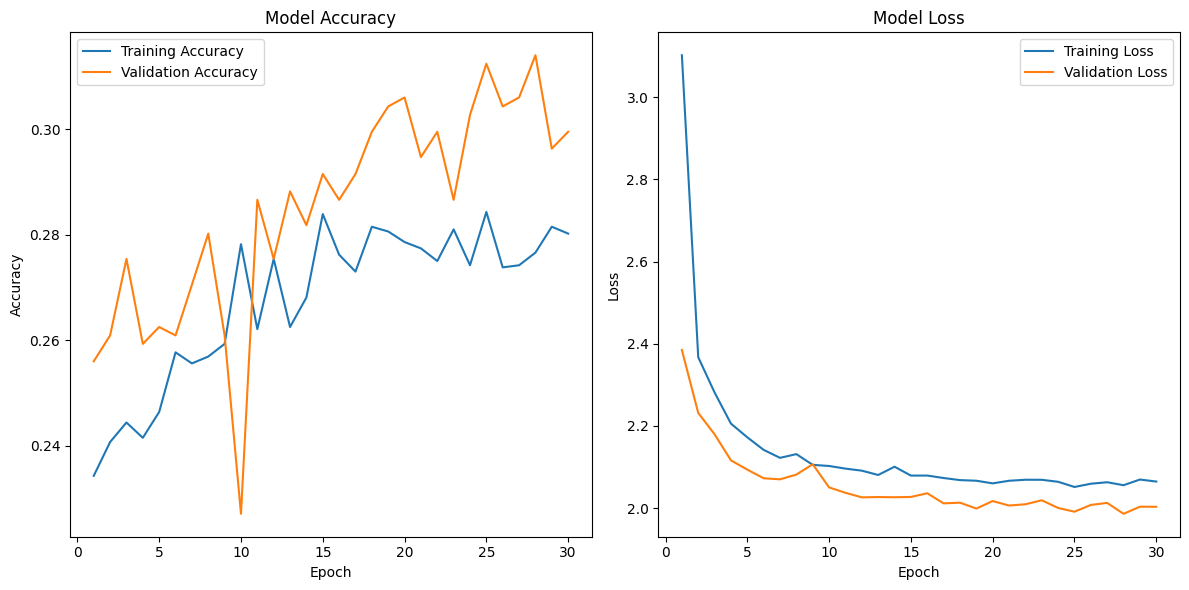

In [ ]:
# import matplotlib.pyplot as plt

# # Define the data
# epochs = list(range(1, 31))  # Assuming 30 epochs
# train_loss = [3.1024, 2.3673, 2.2814, 2.2056, 2.1723, 2.1417, 2.1223, 2.1314, 2.1052, 2.1025, 2.0961, 2.0911, 2.0806, 2.1007, 2.0791, 2.0792, 2.0732, 2.0681, 2.0666, 2.0602, 2.0665, 2.0690, 2.0689, 2.0640, 2.0514, 2.0593, 2.0629, 2.0557, 2.0695, 2.0646]
# val_loss = [2.3848, 2.2317, 2.1796, 2.1162, 2.0936, 2.0726, 2.0700, 2.0816, 2.1067, 2.0504, 2.0372, 2.0261, 2.0269, 2.0264, 2.0271, 2.0361, 2.0115, 2.0132, 1.9988, 2.0171, 2.0062, 2.0093, 2.0190, 2.0003, 1.9912, 2.0077, 2.0126, 1.9861, 2.0034, 2.0032]
# train_accuracy = [0.2343, 0.2407, 0.2444, 0.2415, 0.2464, 0.2577, 0.2556, 0.2569, 0.2593, 0.2782, 0.2621, 0.2754, 0.2625, 0.2681, 0.2839, 0.2762, 0.2730, 0.2815, 0.2806, 0.2786, 0.2774, 0.2750, 0.2810, 0.2742, 0.2843, 0.2738, 0.2742, 0.2766, 0.2815, 0.2802]
# val_accuracy = [0.2560, 0.2609, 0.2754, 0.2593, 0.2625, 0.2609, 0.2705, 0.2802, 0.2609, 0.2271, 0.2866, 0.2754, 0.2882, 0.2818, 0.2915, 0.2866, 0.2915, 0.2995, 0.3043, 0.3060, 0.2947, 0.2995, 0.2866, 0.3027, 0.3124, 0.3043, 0.3060, 0.3140, 0.2963, 0.2995]

# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


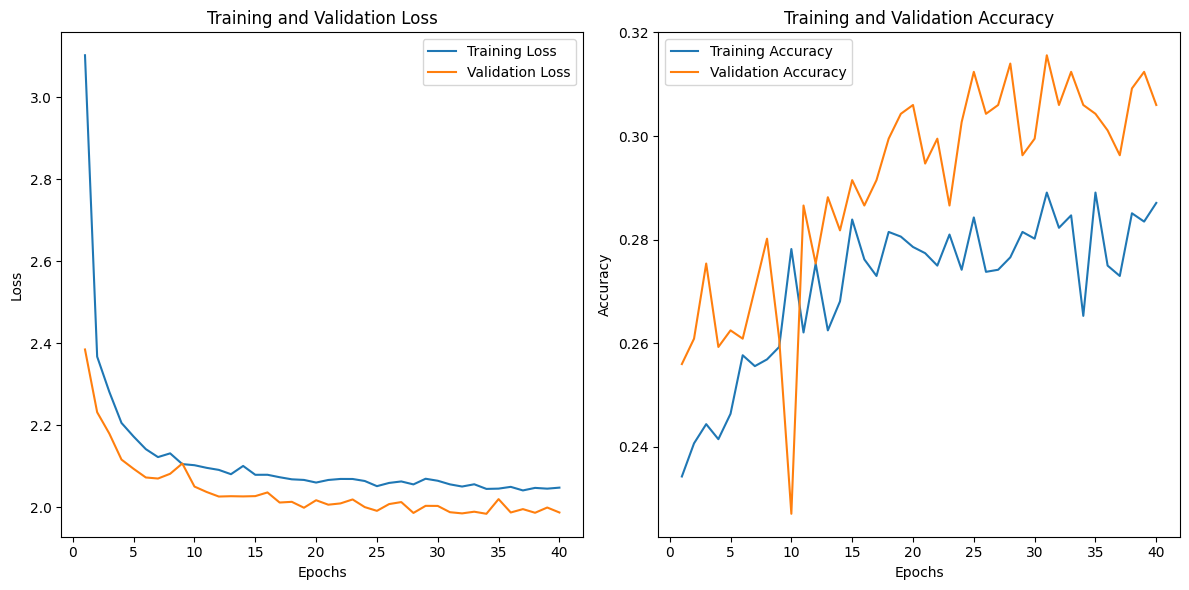

In [ ]:
# # Extend the data
# epochs.extend(list(range(31, 41)))
# train_loss.extend([2.0558, 2.0505, 2.0560, 2.0447, 2.0454, 2.0497, 2.0410, 2.0472, 2.0453, 2.0478])
# val_loss.extend([1.9879, 1.9850, 1.9891, 1.9840, 2.0198, 1.9872, 1.9954, 1.9865, 1.9993, 1.9872])
# train_accuracy.extend([0.2891, 0.2823, 0.2847, 0.2653, 0.2891, 0.2750, 0.2730, 0.2851, 0.2835, 0.2871])
# val_accuracy.extend([0.3156, 0.3060, 0.3124, 0.3060, 0.3043, 0.3011, 0.2963, 0.3092, 0.3124, 0.3060])

# # Plot the data
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_loss, label='Training Loss')
# plt.plot(epochs, val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy plot
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracy, label='Training Accuracy')
# plt.plot(epochs, val_accuracy, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
#This was without l2 reg

'''
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for an overview of the architecture
model.summary()'''

In [ ]:
'''
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')'''

In [ ]:
'''
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''